# Features selection

En este apartado se discute el modelado de la info. Escencialmente, que vamos a analizar con la informacion ya preprocesada. Para este ejercicio vamos a tomar de referencia el df de prueba quese ha preprocesado, realziar algunas pruebas de correlacion, reduccion de dimensionalidad y demas.

In [2]:
# External libraries
import pandas as pd
import numpy as np
import janitor
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Features engineersing
from sklearn.preprocessing import StandardScaler

# Own libraries
sys.path.append(os.path.abspath("../scripts"))
import utils

In [3]:
# reading files
test = pd.read_csv('../data/processed/test_processed.csv')
train = pd.read_csv('../data/processed/train_processed.csv')
train, categoricas, continuas = utils.identificacion_categoricas_continuas(train, threshold=15)
train.shape

(1949, 28)

In [5]:
train.columns

Index(['id_cliente', 'fecha_desembolso', 'incumplimiento', 'tipo_cliente',
       'desv_retiros_atm_12m', 'monto_min_transado_1m',
       'monto_min_transado_2m', 'desv_recargas_pse_12m',
       'prom_retiros_atm_12m', 'version_sistema_operativo',
       'cupo_disp_rotativo', 'meses_cancel_telcos',
       'porcentaje_productos_48meses_total',
       'meses_apertura_ultimo_prod_total', 'meses_apertura_telcos',
       'meses_apertura_rotativo', 'porcentaje_cartera_vencida_telcos',
       'saldo_prom_rotativo', 'uso_total_prod_3m_rotativo',
       'cupo_max_rotativo', 'part_ahorro_total',
       'pct_productos_cerrados_rotativo', 'meses_apertura_ahorro',
       'productos_abiertos_ahorro', 'saldo_total_9_meses_rotativo',
       'cancel_pos_12m', 'ponderacion_reportes_al_dia_18m_total',
       'ponderacion_24m_rotativo'],
      dtype='object')

In [181]:
train["tipo_cliente"].value_counts()

tipo_cliente
adicion     1623
objetivo     326
Name: count, dtype: int64

`Un gran dilema...`

¿Tomar o no en cuenta la totalidad de los 1623 datos de adicion? Esto podria afectar de manera positiva (o no) el rendimiento del modelo. Probemos ambos caminos...

In [182]:
def balanceo_categorias(df): # funcion al modulo utils
    objetivo = df[df['tipo_cliente'] == 'objetivo']
    adicion = df[df['tipo_cliente'] == 'adicion']
    n =  int(np.ceil(0.5*objetivo.shape[0]))
    muestra = adicion.sample(n, random_state=1998)
    return pd.concat([objetivo, muestra])
print(train.shape)
train_sub = balanceo_categorias(train)
print(train_sub.shape)

(1949, 28)
(489, 28)


In [183]:
from scipy.stats import pointbiserialr

correlaciones = {}

for col in continuas:
    coef, _ = pointbiserialr(train[col], train['incumplimiento'])
    correlaciones[col] = coef

correlaciones_ordenadas = dict(sorted(correlaciones.items(), key=lambda item: abs(item[1]), reverse=True))

# Imprimir las variables ordenadas por su correlación con incumplimiento
for var, coef in correlaciones_ordenadas.items():
    print(f'Correlación entre {var} e incumplimiento: {coef:.2f}')


Correlación entre ponderacion_reportes_al_dia_18m_total e incumplimiento: -0.21
Correlación entre porcentaje_cartera_vencida_telcos e incumplimiento: 0.16
Correlación entre ponderacion_24m_rotativo e incumplimiento: -0.16
Correlación entre uso_total_prod_3m_rotativo e incumplimiento: 0.14
Correlación entre cupo_disp_rotativo e incumplimiento: -0.12
Correlación entre pct_productos_cerrados_rotativo e incumplimiento: -0.09
Correlación entre porcentaje_productos_48meses_total e incumplimiento: 0.07
Correlación entre desv_retiros_atm_12m e incumplimiento: 0.07
Correlación entre cupo_max_rotativo e incumplimiento: -0.07
Correlación entre meses_apertura_rotativo e incumplimiento: -0.06
Correlación entre part_ahorro_total e incumplimiento: -0.05
Correlación entre meses_cancel_telcos e incumplimiento: -0.05
Correlación entre meses_apertura_telcos e incumplimiento: -0.05
Correlación entre desv_recargas_pse_12m e incumplimiento: 0.05
Correlación entre prom_retiros_atm_12m e incumplimiento: 0.04


In [184]:

correlaciones = {}

for col in continuas:
    coef, _ = pointbiserialr(train_sub[col], train_sub['incumplimiento'])
    correlaciones[col] = coef

correlaciones_ordenadas = dict(sorted(correlaciones.items(), key=lambda item: abs(item[1]), reverse=True))

# Imprimir las variables ordenadas por su correlación con incumplimiento
for var, coef in correlaciones_ordenadas.items():
    print(f'Correlación entre {var} e incumplimiento: {coef:.2f}')

Correlación entre ponderacion_reportes_al_dia_18m_total e incumplimiento: -0.09
Correlación entre part_ahorro_total e incumplimiento: -0.09
Correlación entre cupo_disp_rotativo e incumplimiento: -0.07
Correlación entre desv_recargas_pse_12m e incumplimiento: 0.06
Correlación entre porcentaje_productos_48meses_total e incumplimiento: 0.06
Correlación entre ponderacion_24m_rotativo e incumplimiento: -0.06
Correlación entre id_cliente e incumplimiento: -0.05
Correlación entre desv_retiros_atm_12m e incumplimiento: 0.05
Correlación entre cupo_max_rotativo e incumplimiento: -0.05
Correlación entre uso_total_prod_3m_rotativo e incumplimiento: 0.04
Correlación entre porcentaje_cartera_vencida_telcos e incumplimiento: 0.04
Correlación entre saldo_total_9_meses_rotativo e incumplimiento: -0.04
Correlación entre cancel_pos_12m e incumplimiento: -0.04
Correlación entre meses_apertura_ahorro e incumplimiento: 0.03
Correlación entre prom_retiros_atm_12m e incumplimiento: 0.03
Correlación entre mont

`Correlaciones categoricas`

Vamos a ver correlacion de chi2 y Kruskal-wallis

In [185]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder


`Chi cuadrado`

In [186]:

# Codificar las variables categóricas como números
le = LabelEncoder()
for var in categoricas:
    train[var] = le.fit_transform(train[var])

# Usar la prueba chi2 para evaluar la importancia
X_categoricas = train[categoricas]
y = train['incumplimiento']

chi_scores, p_values = chi2(X_categoricas, y)
for i in range(len(categoricas)):
    print(f"Variable: {categoricas[i]}, Chi2 Score: {chi_scores[i]}, p-value: {p_values[i]}")

# Nada de lo enontrado aca es relevante para la variable de incidencia

Variable: fecha_desembolso, Chi2 Score: 0.7951389716188196, p-value: 0.37255072273759626
Variable: incumplimiento, Chi2 Score: 1847.0000000000002, p-value: 0.0
Variable: tipo_cliente, Chi2 Score: 0.054527741788502115, p-value: 0.8153640392317011
Variable: version_sistema_operativo, Chi2 Score: 2.1836714346140385, p-value: 0.13948137656217863
Variable: productos_abiertos_ahorro, Chi2 Score: 0.19189061532572815, p-value: 0.661347711190462


`Cramer's V`

In [187]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    tabla_contingencia = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
    n = tabla_contingencia.sum().sum()
    cramers_v_value = np.sqrt(chi2 / (n * (min(tabla_contingencia.shape) - 1)))
    return cramers_v_value

for var in categoricas:
    valor_cramers_v = cramers_v(train[var], train['incumplimiento'])
    print(f"Variable: {var}, Cranmr's V: {valor_cramers_v:.4f}")

Variable: fecha_desembolso, Cranmr's V: 0.0709
Variable: incumplimiento, Cranmr's V: 0.9948
Variable: tipo_cliente, Cranmr's V: 0.0027
Variable: version_sistema_operativo, Cranmr's V: 0.0737
Variable: productos_abiertos_ahorro, Cranmr's V: 0.0590


`Kruskal-Wallis`

In [188]:
from scipy.stats import kruskal

resultados_kruskal = {}
for var in continuas:
    grupo_0 = train[train['incumplimiento'] == 0][var]
    grupo_1 = train[train['incumplimiento'] == 1][var]
    stat, p_value = kruskal(grupo_0, grupo_1)
    resultados_kruskal[var] = p_value

# Ordenar y mostrar los resultados por valor p
resultados_kruskal_ordenados = dict(sorted(resultados_kruskal.items(), key=lambda item: item[1]))

for var, p_value in resultados_kruskal_ordenados.items():
    print(f"Variable: {var}, p-value: {p_value:.4f}")

Variable: ponderacion_reportes_al_dia_18m_total, p-value: 0.0000
Variable: cupo_disp_rotativo, p-value: 0.0000
Variable: uso_total_prod_3m_rotativo, p-value: 0.0000
Variable: porcentaje_cartera_vencida_telcos, p-value: 0.0000
Variable: ponderacion_24m_rotativo, p-value: 0.0000
Variable: cupo_max_rotativo, p-value: 0.0000
Variable: pct_productos_cerrados_rotativo, p-value: 0.0002
Variable: desv_retiros_atm_12m, p-value: 0.0002
Variable: porcentaje_productos_48meses_total, p-value: 0.0004
Variable: prom_retiros_atm_12m, p-value: 0.0012
Variable: part_ahorro_total, p-value: 0.0078
Variable: cancel_pos_12m, p-value: 0.0090
Variable: meses_apertura_rotativo, p-value: 0.0105
Variable: meses_apertura_telcos, p-value: 0.0319
Variable: desv_recargas_pse_12m, p-value: 0.1648
Variable: id_cliente, p-value: 0.1697
Variable: meses_cancel_telcos, p-value: 0.2030
Variable: meses_apertura_ultimo_prod_total, p-value: 0.2256
Variable: saldo_prom_rotativo, p-value: 0.2409
Variable: meses_apertura_ahorro,

In [189]:
from scipy.stats import kruskal

resultados_kruskal = {}
for var in continuas:
    grupo_0 = train_sub[train_sub['incumplimiento'] == 0][var]
    grupo_1 = train_sub[train_sub['incumplimiento'] == 1][var]
    stat, p_value = kruskal(grupo_0, grupo_1)
    resultados_kruskal[var] = p_value

# Ordenar y mostrar los resultados por valor p
resultados_kruskal_ordenados = dict(sorted(resultados_kruskal.items(), key=lambda item: item[1]))

for var, p_value in resultados_kruskal_ordenados.items():
    print(f"Variable: {var}, p-value: {p_value:.4f}")

Variable: ponderacion_reportes_al_dia_18m_total, p-value: 0.0002
Variable: cancel_pos_12m, p-value: 0.0154
Variable: part_ahorro_total, p-value: 0.0258
Variable: desv_retiros_atm_12m, p-value: 0.0349
Variable: prom_retiros_atm_12m, p-value: 0.0544
Variable: cupo_disp_rotativo, p-value: 0.1526
Variable: uso_total_prod_3m_rotativo, p-value: 0.1778
Variable: porcentaje_productos_48meses_total, p-value: 0.1955
Variable: id_cliente, p-value: 0.2343
Variable: porcentaje_cartera_vencida_telcos, p-value: 0.3346
Variable: desv_recargas_pse_12m, p-value: 0.3398
Variable: ponderacion_24m_rotativo, p-value: 0.3467
Variable: saldo_prom_rotativo, p-value: 0.4173
Variable: cupo_max_rotativo, p-value: 0.5866
Variable: monto_min_transado_2m, p-value: 0.6232
Variable: saldo_total_9_meses_rotativo, p-value: 0.6839
Variable: pct_productos_cerrados_rotativo, p-value: 0.7476
Variable: meses_apertura_ultimo_prod_total, p-value: 0.7885
Variable: meses_apertura_rotativo, p-value: 0.8520
Variable: meses_apertur

`insights`

La idea de todo este proeso era empezar a identificar aquellas variables que se podrian relacionar de manera directa para con el incumplimiento o no del pago. Ahora ya que tenemos esto, tenemos argumetnos para escoger algunas variables sobre otras. ¿Estas variables son explicartivas desde una perspetva del negocio? Esto es parte de la conversacion que ha de tenerse con el equipo. por ahora y a falta de contexto, se opta por tener en cuenta solo aquellas variables que son **estadisticamente signifiucativas** dado el valor p menos a 0.05

Dado este contexto, se eliminan practicamente todas las variables categoricas. Tambien, las continuas parecen relevantes. Un metodo de seleccion automatico podria ser util.

Nota: Al tener en cuenta que el dataset con mayor numero de valroes p es el que considera toda la poblacion sin discriminar opr objetivo y adicion, se decide finalmente trabajar con este dataframe.

# Regresion Lasso

In [190]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()

In [191]:
categoricas = ['productos_abiertos_ahorro', 'version_sistema_operativo']
# Variables seleccionadas
variables_seleccionadas = categoricas + continuas

# Extraer las columnas seleccionadas del conjunto de entrenamiento
X_train = train[variables_seleccionadas]
y_train = train['incumplimiento']  # 'incumplimiento' es la variable objetivo

# Aplicar one-hot encoding a las variables categóricas
X_train_encoded = pd.get_dummies(X_train, columns=categoricas, drop_first=True)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)

# Aplicar LassoCV para seleccionar las variables más importantes
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

# Mostrar los coeficientes de las variables seleccionadas por Lasso
lasso_coef = pd.Series(lasso.coef_, index=X_train_encoded.columns)
lasso_coef_sorted = lasso_coef[lasso_coef != 0].sort_values(ascending=False)
print(lasso_coef_sorted)

porcentaje_cartera_vencida_telcos        0.020664
uso_total_prod_3m_rotativo               0.010966
version_sistema_operativo_6              0.009400
porcentaje_productos_48meses_total       0.005906
productos_abiertos_ahorro_4              0.004385
productos_abiertos_ahorro_8              0.002353
desv_recargas_pse_12m                    0.002221
desv_retiros_atm_12m                     0.002207
monto_min_transado_2m                    0.000362
version_sistema_operativo_2              0.000242
saldo_prom_rotativo                     -0.000905
productos_abiertos_ahorro_2             -0.002285
cupo_max_rotativo                       -0.002373
id_cliente                              -0.002924
pct_productos_cerrados_rotativo         -0.006700
part_ahorro_total                       -0.007239
cupo_disp_rotativo                      -0.008830
ponderacion_24m_rotativo                -0.010824
ponderacion_reportes_al_dia_18m_total   -0.023321
dtype: float64


Con esto se tiene una idea general del modelo sin embargo seria bueno optmizr el hiperparametro asociado a el modelo Lasso entonces:

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
# varios rangos de valores para el alda
alpha_range = {'alpha': np.logspace(-4, 4, 100)} 
lasso_model = Lasso()

# Puna gruid search para el alpha
grid_search = GridSearchCV(lasso_model, param_grid=alpha_range, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best alpha value
print("Best alpha value:", grid_search.best_params_)


Best alpha value: {'alpha': np.float64(0.0041320124001153384)}


# Entrando modelo

In [193]:

best_alpha = 0.0041320124001153384

lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

lasso_best_coef = pd.Series(lasso_best.coef_, index=X_train_encoded.columns)
lasso_best_coef_sorted = lasso_best_coef[lasso_best_coef != 0].sort_values(ascending=False)

print("Variables seleccionadas por Lasso (con mejor alpha):\n", lasso_best_coef_sorted)


Variables seleccionadas por Lasso (con mejor alpha):
 porcentaje_cartera_vencida_telcos        0.020764
uso_total_prod_3m_rotativo               0.011065
version_sistema_operativo_6              0.009523
porcentaje_productos_48meses_total       0.005996
productos_abiertos_ahorro_4              0.004551
productos_abiertos_ahorro_8              0.002502
desv_recargas_pse_12m                    0.002298
desv_retiros_atm_12m                     0.002253
monto_min_transado_2m                    0.000479
version_sistema_operativo_2              0.000374
saldo_prom_rotativo                     -0.001035
productos_abiertos_ahorro_2             -0.002380
cupo_max_rotativo                       -0.002445
id_cliente                              -0.003055
pct_productos_cerrados_rotativo         -0.006743
part_ahorro_total                       -0.007415
cupo_disp_rotativo                      -0.008832
ponderacion_24m_rotativo                -0.010910
ponderacion_reportes_al_dia_18m_total   -0.023

Esto es meramente para la seleccion de vaiable s que seran usadas apra el modelo. Entonces en este proceso se procede a realizar el modelo de clasifiicacion con estas variables


In [194]:
variables_lasso = [
    'porcentaje_cartera_vencida_telcos', 'uso_total_prod_3m_rotativo', 
    'version_sistema_operativo_6', 'porcentaje_productos_48meses_total', 
    'productos_abiertos_ahorro_4', 'productos_abiertos_ahorro_8', 
    'desv_recargas_pse_12m', 'desv_retiros_atm_12m', 'monto_min_transado_2m', 
    'version_sistema_operativo_2', 'saldo_prom_rotativo', 
    'productos_abiertos_ahorro_2', 'cupo_max_rotativo', 'id_cliente', 
    'pct_productos_cerrados_rotativo', 'part_ahorro_total', 
    'cupo_disp_rotativo', 'ponderacion_24m_rotativo', 
    'ponderacion_reportes_al_dia_18m_total'
]
print(continuas)
print(categoricas)


['id_cliente', 'desv_retiros_atm_12m', 'monto_min_transado_1m', 'monto_min_transado_2m', 'desv_recargas_pse_12m', 'prom_retiros_atm_12m', 'cupo_disp_rotativo', 'meses_cancel_telcos', 'porcentaje_productos_48meses_total', 'meses_apertura_ultimo_prod_total', 'meses_apertura_telcos', 'meses_apertura_rotativo', 'porcentaje_cartera_vencida_telcos', 'saldo_prom_rotativo', 'uso_total_prod_3m_rotativo', 'cupo_max_rotativo', 'part_ahorro_total', 'pct_productos_cerrados_rotativo', 'meses_apertura_ahorro', 'saldo_total_9_meses_rotativo', 'cancel_pos_12m', 'ponderacion_reportes_al_dia_18m_total', 'ponderacion_24m_rotativo']
['productos_abiertos_ahorro', 'version_sistema_operativo']


In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
# Load the datasets
new_train =pd.read_csv('../data/processed/train_processed.csv')
new_test = pd.read_csv('../data/processed/test_processed.csv')

# Filter the selected variables for Lasso regression
selected_columns_new = [col for col in variables_lasso if col in new_train.columns]

# Separate the features (X) and the target (y)
X_train_new = new_train[selected_columns_new]
y_train_new = new_train['incumplimiento']

X_test_new = new_test[selected_columns_new]

# Normalizing the continuous variables
scaler = StandardScaler()
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_test_scaled_new = scaler.transform(X_test_new)

# Fit a logistic regression model with the new preprocessed data
log_reg_new = LogisticRegression(max_iter=1000)
log_reg_new.fit(X_train_scaled_new, y_train_new)

# Make predictions
y_pred_train_new = log_reg_new.predict(X_train_scaled_new)

# Evaluating the model on the training set
train_accuracy_new = accuracy_score(y_train_new, y_pred_train_new)
train_accuracy_new


0.9497178040020523

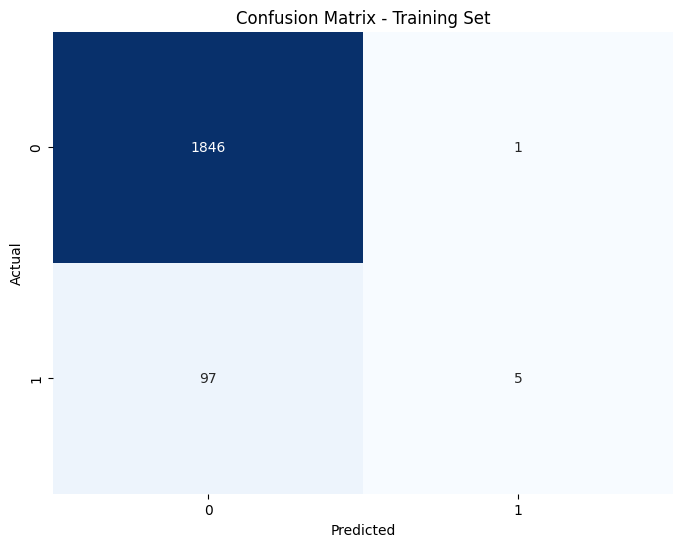

In [199]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix = confusion_matrix(y_train_new, y_pred_train_new)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Training Set")
plt.show()


In [201]:
np.logspace(-4, 4, 100)

array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-03, 5.99484250e-03, 7.22080902e-03,
       8.69749003e-03, 1.04761575e-02, 1.26185688e-02, 1.51991108e-02,
       1.83073828e-02, 2.20513074e-02, 2.65608778e-02, 3.19926714e-02,
       3.85352859e-02, 4.64158883e-02, 5.59081018e-02, 6.73415066e-02,
       8.11130831e-02, 9.77009957e-02, 1.17681195e-01, 1.41747416e-01,
       1.70735265e-01, 2.05651231e-01, 2.47707636e-01, 2.98364724e-01,
       3.59381366e-01, 4.32876128e-01, 5.21400829e-01, 6.28029144e-01,
       7.56463328e-01, 9.11162756e-01, 1.09749877e+00, 1.32194115e+00,
       1.59228279e+00, 1.91791026e+00, 2.31012970e+00, 2.78255940e+00,
      

# Rdge - Lasso - PCA

El objetivo de este ejercicio es finalmente generar una prediccion que sea fuerte desde lo teorico. Ridge penaliza ante el supuesto de que hay algunas variables que tienen mayor preponderancia que otrsa (esto se vio desde el descriptivo *no es este caso*). Lasso por otro lado busca penalizar con hipermparametro de 'suavizdo'esto es bueno en tanto se sospéchja todas las features aportan un poco pero no es claro cual es la que mas.

**Con mayor tiempo y poder computacional se podria proponer** un ejercicio en el cual se use tanto Ridge como Lasso con diferentes modelos ajustados con cada uno de estos. Crear una 'malla' de modelos en los cuales a cada uno se le asigne un id, puntaje de error de clasificacin y escger el mejor pero obvio, esto requiere tiempoy esfuerzso computacional. Y lamentablemente mi abue en el hospital y el trabajo no me permite tener mucho tiempo. Y mi Corei 5 de 8va generacion tampoco ayuda... Pero esto es algo a tener presente.

Por otro lado PCA es un excelente analisis suponiendo linealida entre los datos. Permite de manera directa capturar toda la variabildiad posible con un 'simple' cambio de ejes. Ahora bien... Si la data no es lineal o si la interpretacion es relevante... Valió madres PCA. Aun asi se procede a ejecutar el analisis con PCA y Lasso. Veamos que nos depara el analisis en el modelado. 


Sobra decir que **este parrafo no lo escribió ChatGPT**. No todo puede ser una IA, ¿O si?

NOTA: A falta de tiempo, meto PCA directamente en el Script. No hubo poder computacional en el EDAE paraa mirar histogramas ed los dataframes completos. Aunque reconozco que es alog extraño... En fin. COntinuad leyendo el analisis c: